### 1. Title & Executive Summary

This project builds an end-to-end churn prediction system for a SaaS product using realistic, multi-table telemetry data.  
The objective is to identify accounts at risk of churn within the next **30 days**, enabling proactive retention actions.
Using leakage-safe weekly snapshots, interpretable feature engineering, and time-based validation, the final model ranks churn risk effectively and delivers actionable business insights without relying on dashboards.

### 2. Dataset Overview
The analysis uses the **RavenStack** synthetic SaaS dataset, designed to simulate real-world product telemetry and customer lifecycles.

**Data characteristics:**
- 5 relational tables (accounts, subscriptions, usage, support, churn)
- Coverage: January 2023 – December 2024
- Referential integrity enforced across all entities
- Includes realistic edge cases (trials, upgrades, downgrades, reactivations)

All data is fully synthetic and contains no PII.

Dataset Link: https://www.kaggle.com/datasets/rivalytics/saas-subscription-and-churn-analytics-dataset

### 3. Problem Definition

**Objective:**  
Predict whether a customer account will churn within the next **30 days**.

**Modeling setup:**
- Weekly prediction cadence (every Monday)
- One row represents an account at a point in time
- Churn labels are forward-looking to prevent data leakage

This framing mirrors how churn models are deployed in production SaaS environments.

### 4. Approach

The modeling pipeline follows a structured, production-oriented workflow:

1. **Data Audit & Validation**  
   Verified schema integrity, missing values, and temporal consistency.

2. **Data Processing (Snapshot Construction)**  
   Created weekly, leakage-safe account snapshots with forward churn labels.

3. **Feature Engineering**  
   Engineered a small, interpretable feature set capturing:
   - Product usage behavior
   - Support friction
   - Subscription stability
   - Account maturity

4. **Modeling & Selection**  
   - Logistic Regression (baseline and tuned)
   - Gradient Boosting (challenger)
   - Time-based train/validation/test split

5. **Evaluation**  
   Models are evaluated using ranking metrics and business-aligned thresholds rather than default classification cutoffs.

### 5. Results

In [1]:
import json
import pandas as pd

with open("../reports/model_evaluation_results.json", "r") as f:
    results = json.load(f)

results.keys()

dict_keys(['lr_meta', 'hgb_meta', 'evaluation'])

In [2]:
evals = results["evaluation"]

comparison = pd.DataFrame([
    evals["lr_val"],
    evals["lr_test"],
    evals["hgb_val"],
    evals["hgb_test"],
])[["label","roc_auc","pr_auc","precision_churn_topk","recall_churn_topk","churners_per_100_contacted"]]

comparison

,label,roc_auc,pr_auc,precision_churn_topk,recall_churn_topk,churners_per_100_contacted
0,LR_VAL,0.612874,0.158946,0.183047,0.337868,18.304668
1,LR_TEST,0.673340,0.264622,0.312364,0.421053,31.236443
2,HGB_VAL,0.585692,0.130840,0.146192,0.269841,14.619165
3,HGB_TEST,0.642454,0.222927,0.234273,0.315789,23.427332


The table below compares validation and test performance across models using ROC-AUC, PR-AUC, and ranked outreach metrics.

In [3]:
def pretty_cm(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    return f"TN={tn}, FP={fp}, FN={fn}, TP={tp}"

for k in ["lr_val","lr_test","hgb_val","hgb_test"]:
    print(k.upper(), ":", pretty_cm(evals[k]["confusion_matrix"]))

LR_VAL : TN=2962, FP=665, FN=292, TP=149
LR_TEST : TN=1643, FP=317, FN=198, TP=144
HGB_VAL : TN=2932, FP=695, FN=322, TP=119
HGB_TEST : TN=1607, FP=353, FN=234, TP=108


Confusion matrices are computed using a **Top-20% risk threshold**, reflecting a realistic retention outreach budget.

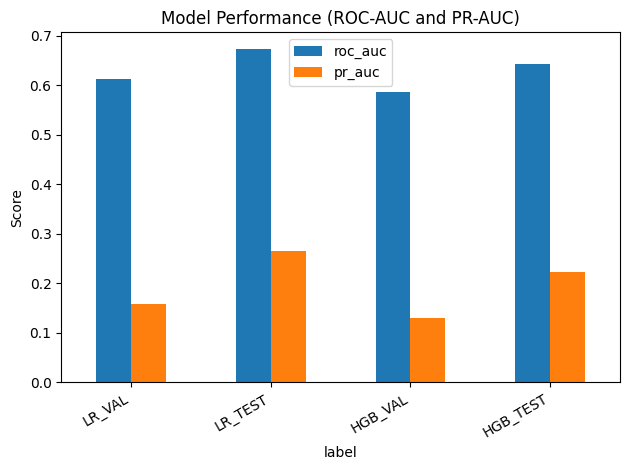

In [4]:
import matplotlib.pyplot as plt

plot_df = comparison.set_index("label")[["roc_auc","pr_auc"]]
plot_df.plot(kind="bar")
plt.title("Model Performance (ROC-AUC and PR-AUC)")
plt.ylabel("Score")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

The chart highlights overall ranking performance differences between models.

### 6. Business Interpretation

In [5]:
def narrative(res):
    pct = int(res["top_pct"] * 100)
    return (
        f"{res['label']}: Contact top {pct}% highest-risk accounts → "
        f"recall {res['recall_churn_topk']:.1%}, precision {res['precision_churn_topk']:.1%} "
        f"({res['churners_per_100_contacted']:.1f} churners per 100 contacted)."
    )

for k in ["lr_val","lr_test","hgb_val","hgb_test"]:
    print(narrative(evals[k]))

LR_VAL: Contact top 20% highest-risk accounts → recall 33.8%, precision 18.3% (18.3 churners per 100 contacted).
LR_TEST: Contact top 20% highest-risk accounts → recall 42.1%, precision 31.2% (31.2 churners per 100 contacted).
HGB_VAL: Contact top 20% highest-risk accounts → recall 27.0%, precision 14.6% (14.6 churners per 100 contacted).
HGB_TEST: Contact top 20% highest-risk accounts → recall 31.6%, precision 23.4% (23.4 churners per 100 contacted).


Rather than using a fixed probability threshold (e.g., 0.5), the model is evaluated as a **ranking system**, which better reflects how churn models are used operationally.

### 7. Key Takeaways

- A tuned **Logistic Regression** model outperformed a tree-based model due to the deliberately aggregated and interpretable feature design.
- Default probability thresholds are inappropriate for imbalanced churn problems.
- Ranking-based evaluation enables clear trade-offs between recall and outreach capacity.
- Time-based validation improves confidence in real-world performance.

### 8. Limitations & Next Steps

**Limitations:**
- Feature set focuses on aggregated signals rather than raw event-level interactions.
- No uplift modeling (who to contact vs who will churn).

**Next steps:**
- Incorporate feature-level usage diversity and error patterns.
- Explore uplift or causal modeling for targeted retention.
- Add monitoring and periodic retraining for production deployment.